In [1]:
from scipy import stats
import pandas as pd
import numpy as np

# Read data set
hd_df = pd.read_csv('heart disease.csv')

## Show Dataset attributes and descriptive stats

In [2]:
# Dataset makeup
print("Dataset")
print(hd_df.head())
print("\nDataset information")
print(hd_df.info())

# Descriptive statistics
print("\nDescriptive Statistics")
print(hd_df.describe())

# Duplicates?
print("\nDuplicate rows:\n", hd_df[hd_df.duplicated()])

Dataset
   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  

Dataset information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          -------

In [3]:
count_zeros_col = (hd_df['RestingBP'] == 0).sum()
print(f"Number of zeros in RestingBP: {count_zeros_col}")

count_zeros_col = (hd_df['Age'] == 0).sum()
print(f"Number of zeros in Age: {count_zeros_col}")

count_zeros_col = (hd_df['Cholesterol'] == 0).sum()
print(f"Number of zeros in Cholesterol: {count_zeros_col}")

Number of zeros in RestingBP: 1
Number of zeros in Age: 0
Number of zeros in Cholesterol: 172


## Drop rows where certain column values are 0.
### Rows will be fewer than 1% of data set.

In [4]:
# Drop records with RestingBP = 0
hd_df = hd_df[hd_df['RestingBP'] != 0]

# Re-index after dropped rows
hd_df = hd_df.reset_index(drop=True)

## Show unique values of categorical columns for creating dummy variables

In [5]:
# Determine unique values in categorical columns
cat_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'FastingBS']

unique_values = {col: hd_df[col].unique().tolist() for col in cat_columns}

for col, values in unique_values.items():
    print(f"Unique values in '{col}': {values}")

Unique values in 'Sex': ['M', 'F']
Unique values in 'ChestPainType': ['ATA', 'NAP', 'ASY', 'TA']
Unique values in 'RestingECG': ['Normal', 'ST', 'LVH']
Unique values in 'ExerciseAngina': ['N', 'Y']
Unique values in 'ST_Slope': ['Up', 'Flat', 'Down']
Unique values in 'FastingBS': [0, 1]


## Transform variables from single character to more descriptive names

In [6]:
# Change M/F to Male/Female so dummy variable column header makes more sense
hd_df['Sex'] = hd_df['Sex'].replace({
    'M': 'Male',
    'F': 'Female'
})

# Change Y/N values to Yes/No so dummy variable column header makes more sense
hd_df['ExerciseAngina'] = hd_df['ExerciseAngina'].replace({
    'N': 'No',
    'Y': 'Yes'
})

# Change 0/1 values to Yes/No so dummy variable column header makes more sense
hd_df['FastingBS'] = hd_df['FastingBS'].replace({
    0: 'No',
    1: 'Yes'
})


## Create binary variables

In [7]:
# Include dummy variables for columns containing binary values
dummy_df1 = pd.get_dummies(hd_df['Sex'], prefix='Sex', drop_first=True, dtype=int)
dummy_df2 = pd.get_dummies(hd_df['ExerciseAngina'], prefix='Ex_Ang', drop_first=True, dtype=int)
dummy_df3 = pd.get_dummies(hd_df['FastingBS'], prefix='FastingBS', drop_first=True, dtype=int)
dummy_df4 = pd.get_dummies(hd_df['ChestPainType'], prefix='ChestPainType', drop_first=True, dtype=int)
dummy_df5 = pd.get_dummies(hd_df['RestingECG'], prefix='RestingECG', drop_first=True, dtype=int)
dummy_df6 = pd.get_dummies(hd_df['ST_Slope'], prefix='ST_Slope', drop_first=True, dtype=int)

hd_df = pd.concat([hd_df, dummy_df1, dummy_df2, dummy_df3, dummy_df4, dummy_df5, dummy_df6], axis=1)


## Create category version of target variable for EDA purposes
#### (Keep binary variable for model learning)

In [8]:
hd_df['HeartDisease_Category'] = hd_df['HeartDisease'].map({0: 'No', 1: 'Yes'})

## Impute values of cholesterol using PMM

In [9]:
# Initialize MICEData with the dataset
from statsmodels.imputation.mice import MICEData
import statsmodels.formula.api as smf

cols_to_include = ['Cholesterol', 'Age', 'RestingBP', 'MaxHR', 'Oldpeak', 'Sex_Male', 'Ex_Ang_Yes',
                   'FastingBS_Yes', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA',
                   'RestingECG_Normal', 'RestingECG_ST', 'ST_Slope_Flat', 'ST_Slope_Up']

# Zeros are treated as true values rather than values to be imputed.
# Replacing the zeros with null will allow the impute algorithm to work as intended
hd_df['Cholesterol'] = hd_df['Cholesterol'].replace(0, np.nan)

mice_data_df = hd_df[cols_to_include].copy() # Algorithm requires numeric columns for predictors

mice_data = MICEData(mice_data_df)

# Specify imputation for Cholesterol using numeric columns
predictor_cols = 'Age + RestingBP + MaxHR + Oldpeak + Sex_Male + Ex_Ang_Yes + FastingBS_Yes + ChestPainType_NAP + ChestPainType_TA + RestingECG_Normal + RestingECG_ST + ST_Slope_Flat + ST_Slope_Up'
mice_data.set_imputer('Cholesterol', formula=predictor_cols)

mice_data.update_all(n_iter=10)  # Run MICE for 10 iterations

# Get the imputed dataset
imputed_data = mice_data.data

In [10]:
# Extract only the imputed column Cholesterol and make new column to check imputing results
hd_df['Imputed_Cholesterol'] = imputed_data['Cholesterol']

# Print number of NaN values in original column
print("\nNumber of rows where Cholestoral = NaN: ", hd_df['Cholesterol'].isna().sum())

# Print number of zero values in imputed column
print("\nNumber of rows where Imputed Cholestoral = 0: ",(hd_df['Imputed_Cholesterol'] == 0).sum())

# Print number of NaN values in imputed column
print("\nNumber of rows where Imputed Cholestoral = NaN: ",hd_df['Imputed_Cholesterol'].isna().sum())

# Side-by-side comparison
print("\n",hd_df.loc[hd_df['Imputed_Cholesterol'] != hd_df['Cholesterol'], ['Cholesterol', 'Imputed_Cholesterol']])



Number of rows where Cholestoral = NaN:  171

Number of rows where Imputed Cholestoral = 0:  0

Number of rows where Imputed Cholestoral = NaN:  0

      Cholesterol  Imputed_Cholesterol
293          NaN                175.0
294          NaN                249.0
295          NaN                205.0
296          NaN                219.0
297          NaN                235.0
..           ...                  ...
513          NaN                275.0
514          NaN                309.0
517          NaN                335.0
534          NaN                305.0
535          NaN                241.0

[171 rows x 2 columns]


## Display results after preparation

In [11]:
# Check results
print("Dataset")
print(hd_df.head())
print("\nDataset information")
print(hd_df.info())
# Descriptive statistics
print("\nDescriptive Statistics")
print(hd_df.describe())

Dataset
   Age     Sex ChestPainType  RestingBP  Cholesterol FastingBS RestingECG  \
0   40    Male           ATA        140        289.0        No     Normal   
1   49  Female           NAP        160        180.0        No     Normal   
2   37    Male           ATA        130        283.0        No         ST   
3   48  Female           ASY        138        214.0        No     Normal   
4   54    Male           NAP        150        195.0        No     Normal   

   MaxHR ExerciseAngina  Oldpeak  ... FastingBS_Yes  ChestPainType_ATA  \
0    172             No      0.0  ...             0                  1   
1    156             No      1.0  ...             0                  0   
2     98             No      0.0  ...             0                  1   
3    108            Yes      1.5  ...             0                  0   
4    122             No      0.0  ...             0                  0   

   ChestPainType_NAP  ChestPainType_TA  RestingECG_Normal  RestingECG_ST  \
0       

## Scale variables

In [12]:
# import the StandardScaler
from sklearn.preprocessing import StandardScaler

cols_to_scale = ['Age', 'RestingBP', 'Imputed_Cholesterol', 'MaxHR', 'Oldpeak']

# Include columns for scaling
hd_number_df = hd_df[cols_to_scale]

# extract out the numerical data and scale it to zero mean and unit standard deviation
scaler = StandardScaler().fit(hd_number_df)

hd_num_scaled_df = pd.DataFrame(scaler.fit_transform(hd_number_df), 
                                columns = hd_number_df.columns, 
                                index = hd_number_df.index)

hd_non_scaled_df = hd_df.drop(columns=cols_to_scale)

hd_scaled_df = pd.concat([hd_num_scaled_df, hd_non_scaled_df], axis=1)

# Find columns with any NaN values; should ONLY be Cholesterol
columns_with_nan = hd_scaled_df.columns[hd_scaled_df.isna().any()].tolist()
print("\nColumns with NaN values:", columns_with_nan)


Columns with NaN values: ['Cholesterol']


## Determine distributions

In [13]:
print("Counts of categorical variables")
print("\n",hd_df['HeartDisease_Category'].value_counts())
print("\n",hd_df['Sex'].value_counts())
print("\n",hd_df['ChestPainType'].value_counts())
print("\n",hd_df['FastingBS'].value_counts())
print("\n",hd_df['RestingECG'].value_counts())
print("\n",hd_df['ST_Slope'].value_counts())

Counts of categorical variables

 HeartDisease_Category
Yes    507
No     410
Name: count, dtype: int64

 Sex
Male      724
Female    193
Name: count, dtype: int64

 ChestPainType
ASY    496
NAP    202
ATA    173
TA      46
Name: count, dtype: int64

 FastingBS
No     703
Yes    214
Name: count, dtype: int64

 RestingECG
Normal    551
LVH       188
ST        178
Name: count, dtype: int64

 ST_Slope
Flat    459
Up      395
Down     63
Name: count, dtype: int64


## Perform different analyses

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))

Matplotlib is building the font cache; this may take a moment.


<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/envs

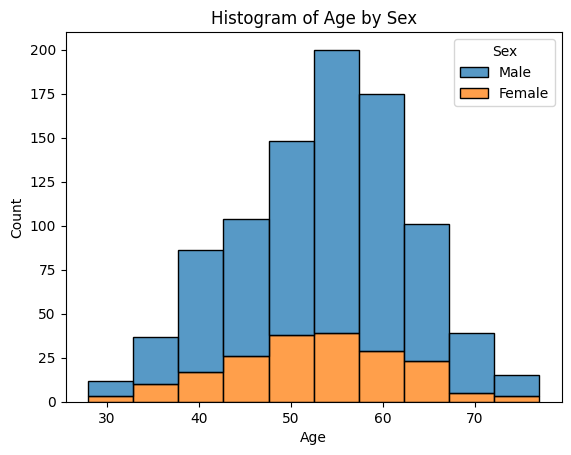

In [15]:
# Plot histogram of Age by Sex
sns.histplot(data=hd_df, x='Age', hue='Sex', multiple='stack', bins=10)
plt.title('Histogram of Age by Sex')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/envs

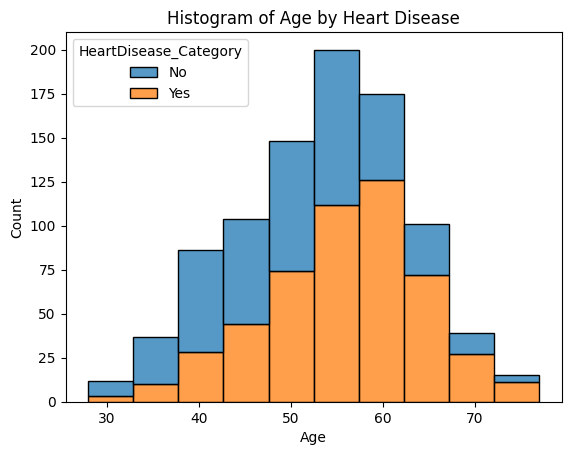

In [16]:
# Plot histogram of Age by Heart Disease
sns.histplot(data=hd_df, x='Age', hue='HeartDisease_Category', multiple='stack', bins=10)
plt.title('Histogram of Age by Heart Disease')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/envs

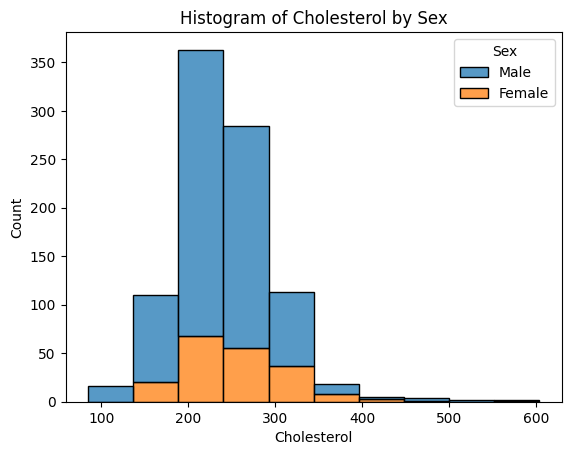

In [17]:
# Plot histogram of Cholesterol by Sex
sns.histplot(data=hd_df, x='Imputed_Cholesterol', hue='Sex', multiple='stack', bins=10)
plt.title('Histogram of Cholesterol by Sex')
plt.xlabel('Cholesterol')
plt.ylabel('Count')
plt.show()

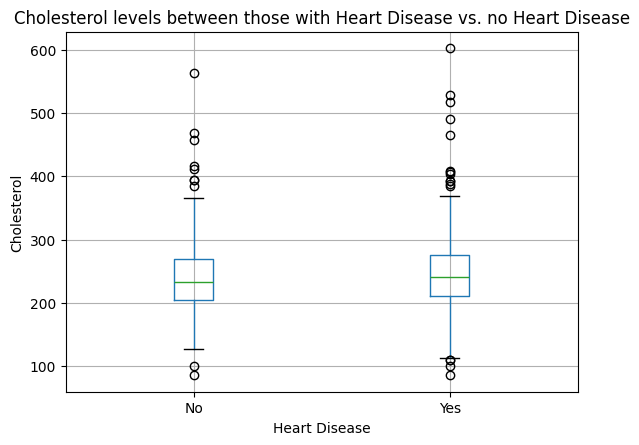

In [18]:
# Plot Box Plot of cholesterol and heart disease
hd_df.boxplot(column='Imputed_Cholesterol', by='HeartDisease_Category')
plt.title('Cholesterol levels between those with Heart Disease vs. no Heart Disease')
plt.suptitle('')  # Remove default title
plt.xlabel('Heart Disease')
plt.ylabel('Cholesterol')
plt.show()

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/envs

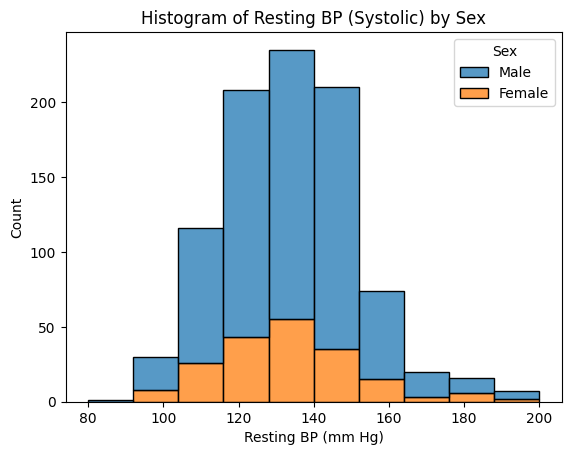

In [19]:
# Plot histogram of Resting BP by Sex
sns.histplot(data=hd_df, x='RestingBP', hue='Sex', multiple='stack', bins=10)
plt.title('Histogram of Resting BP (Systolic) by Sex')
plt.xlabel('Resting BP (mm Hg)')
plt.ylabel('Count')
plt.show()

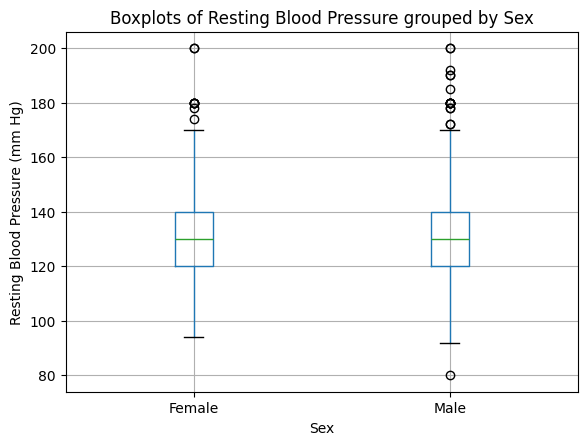

In [20]:
# Plot Box Plot of Resting BP by Sex
hd_df.boxplot(column='RestingBP', by='Sex')
plt.title('Boxplots of Resting Blood Pressure grouped by Sex')
plt.suptitle('')  # Remove default title
plt.xlabel('Sex')
plt.ylabel('Resting Blood Pressure (mm Hg)')
plt.show()

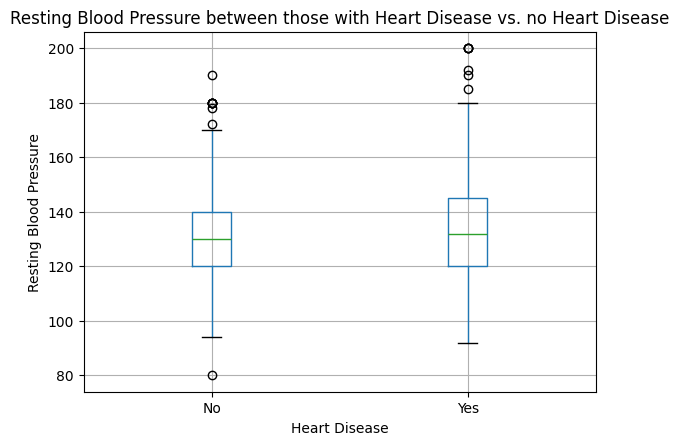

In [21]:
# Plot Box Plot of resting blood pressure and heart disease
hd_df.boxplot(column='RestingBP', by='HeartDisease_Category')
plt.title('Resting Blood Pressure between those with Heart Disease vs. no Heart Disease')
plt.suptitle('')  # Remove default title
plt.xlabel('Heart Disease')
plt.ylabel('Resting Blood Pressure')
plt.show()

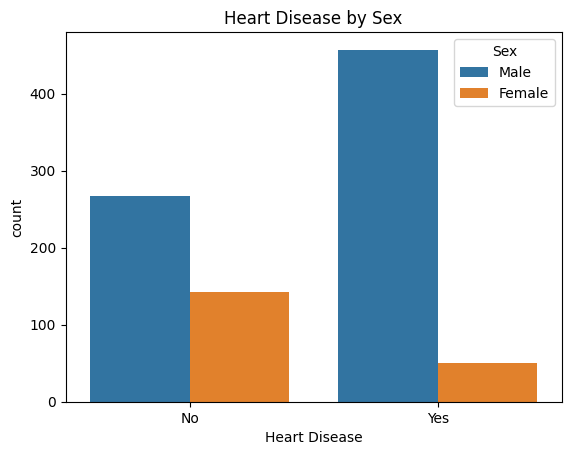

In [22]:
# Grouped Bar Chart of Heart Disease by Sex
sns.countplot(data=hd_df, x='HeartDisease_Category', hue='Sex')
plt.title("Heart Disease by Sex")
plt.xlabel('Heart Disease')
plt.show()

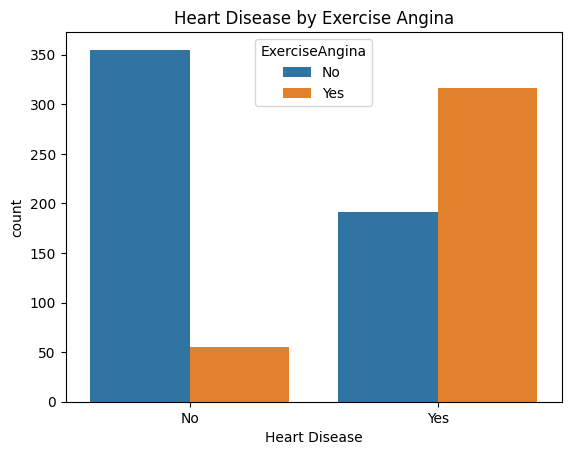

In [23]:
# Grouped Bar Chart of Heart Disease by Exercise Angina
sns.countplot(data=hd_df, x='HeartDisease_Category', hue='ExerciseAngina')
plt.title("Heart Disease by Exercise Angina")
plt.xlabel('Heart Disease')
plt.show()

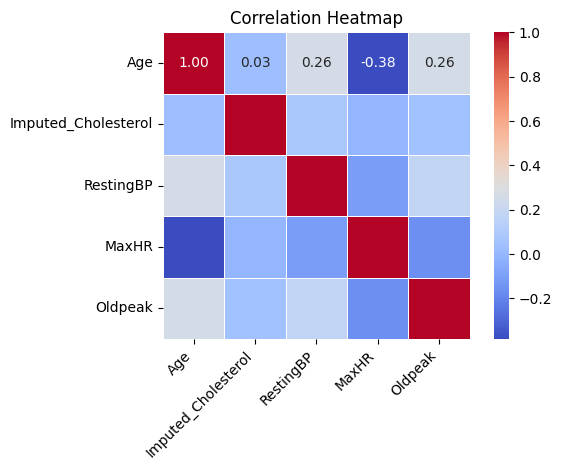

In [24]:
# Compute correlation matrix for only specific columns 
columns_to_correlate = ['Age', 'Imputed_Cholesterol', 'RestingBP', 'MaxHR', 'Oldpeak']
corr_matrix = hd_df[columns_to_correlate].corr()

# Draw the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=.5)
plt.title("Correlation Heatmap")
plt.xticks(rotation=45, ha='right') # 45-degree angle for x-axis labels
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

In [25]:
# Helps me remember what the variables are rather than scrolling to the top :-)
print(hd_scaled_df.columns)

Index(['Age', 'RestingBP', 'Imputed_Cholesterol', 'MaxHR', 'Oldpeak', 'Sex',
       'ChestPainType', 'Cholesterol', 'FastingBS', 'RestingECG',
       'ExerciseAngina', 'ST_Slope', 'HeartDisease', 'Sex_Male', 'Ex_Ang_Yes',
       'FastingBS_Yes', 'ChestPainType_ATA', 'ChestPainType_NAP',
       'ChestPainType_TA', 'RestingECG_Normal', 'RestingECG_ST',
       'ST_Slope_Flat', 'ST_Slope_Up', 'HeartDisease_Category'],
      dtype='object')


## Fit logistic regression model using all features

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# Define features to use in the model
cols_to_use = ['Age', 'RestingBP', 'Imputed_Cholesterol', 'MaxHR', 'Oldpeak', 'Sex_Male', 'Ex_Ang_Yes',
               'FastingBS_Yes', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 
               'RestingECG_Normal', 'RestingECG_ST', 'ST_Slope_Flat', 'ST_Slope_Up']

# Extract target variable (heart disease status)
y = hd_scaled_df['HeartDisease']

# Use feature variables
X = hd_scaled_df[cols_to_use]

# Split data into training (80%) and testing (20%) sets with fixed random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=85)

# Train logistic regression model with increased max_iter to ensure convergence
# Code kept crashing with fewer iterations, so set as 10,000
lr_model = LogisticRegression(max_iter=10000).fit(X_train, y_train)

## Determine probabilities and predictions, report results

In [27]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

# Import necessary evaluation metrics from scikit-learn

# Predict probabilities and classes
y_prob = lr_model.predict_proba(X_test)[:, 1]  # Get probability estimates for positive class (class 1)
y_pred = lr_model.predict(X_test)  # Get class predictions (0 or 1)

# Evaluate the model using multiple metrics
report = classification_report(y_test, y_pred)  # Generate detailed classification metrics
conf_matrix = confusion_matrix(y_test, y_pred)  # Create confusion matrix (TN, FP, FN, TP)
accuracy = accuracy_score(y_test, y_pred)  # Correct predictions / total predictions
auc = roc_auc_score(y_test, y_prob)  # Calculate model's ability to discriminate

# Display evaluation results
print("Confusion Matrix:\n", conf_matrix)
print(f"\nAccuracy: {accuracy:.3f}")
print(f"\nAUC: {auc:.3f}") 
print("\nClassification Report\n",report)

Confusion Matrix:
 [[65  9]
 [13 97]]

Accuracy: 0.880

AUC: 0.943

Classification Report
               precision    recall  f1-score   support

           0       0.83      0.88      0.86        74
           1       0.92      0.88      0.90       110

    accuracy                           0.88       184
   macro avg       0.87      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



## Determine statistically significant features and evaluate which to remove from the model

In [28]:
import statsmodels.api as sm

# Add a constant term to the training and test features
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Initialize a logistic regression model using statsmodels
sm_model = sm.Logit(y_train, X_train_sm)

# Fit the model using Newton's method
sm_result = sm_model.fit(method ='newton')

# Display results
print(sm_result.summary())

# Create a DataFrame of p-values to test for significance
p_values = pd.DataFrame(sm_result.pvalues, columns=['p_value'], index=X_train_sm.columns)

# Flag variables as significant if p-value within 95% confidence level
p_values['significant'] = p_values['p_value'] < 0.05
print("\nP-values and Significance:\n", p_values)

# Display statistically significant variables
significant_vars = p_values[p_values['significant']].index.tolist()
print("\nStatistically Significant Variables (p < 0.05):\n", significant_vars)

Optimization terminated successfully.
         Current function value: 0.341376
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           HeartDisease   No. Observations:                  733
Model:                          Logit   Df Residuals:                      717
Method:                           MLE   Df Model:                           15
Date:                Mon, 02 Jun 2025   Pseudo R-squ.:                  0.5050
Time:                        06:05:36   Log-Likelihood:                -250.23
converged:                       True   LL-Null:                       -505.54
Covariance Type:            nonrobust   LLR p-value:                 3.209e-99
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.3047      0.573     -2.276      0.023      -2.428      -0.181
Ag

## Show important features

In [29]:
feature_importance = pd.Series(abs(lr_model.coef_[0]), index=X.columns).sort_values(ascending=False)
print(feature_importance.sort_values(ascending=False))

Sex_Male               1.508869
ChestPainType_ATA      1.492502
ChestPainType_NAP      1.335820
ST_Slope_Flat          1.305993
ChestPainType_TA       1.058312
Ex_Ang_Yes             0.966903
FastingBS_Yes          0.964454
ST_Slope_Up            0.789752
Oldpeak                0.451986
MaxHR                  0.259230
Age                    0.104192
RestingECG_Normal      0.102723
RestingECG_ST          0.063972
RestingBP              0.055902
Imputed_Cholesterol    0.016621
dtype: float64


## Determine optimal threshold

In [30]:
from sklearn.metrics import roc_curve

# Calculate false positive rate, true positive rate, and thresholds
# y_test contains the actual labels, y_prob contains the predicted probabilities
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Determining the maximum difference between true positive rate and false positive rate
optimal_idx = np.argmax(tpr - fpr)

# Get the threshold value corresponding to the optimal index
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold: .3f}")

Optimal Threshold:  0.338


## Display new results after reducing threshold

In [31]:
# Get predicted values for those that are above the threshold
y_pred_reduced = (y_prob >= optimal_threshold).astype(int)

# Obtain new results using the reduced threshold predictions
conf_matrix_reduced = confusion_matrix(y_test, y_pred_reduced)
report_reduced = classification_report(y_test, y_pred_reduced)
accuracy_reduced = accuracy_score(y_test, y_pred_reduced)

print("\nConfusion Matrix (Reduced Threshold):\n", conf_matrix_reduced)
print(f"\nAccuracy: {accuracy_reduced: .3f}")
print("\nClassification Report (Reduced Threshold):\n", report_reduced)


Confusion Matrix (Reduced Threshold):
 [[ 62  12]
 [  6 104]]

Accuracy:  0.902

Classification Report (Reduced Threshold):
               precision    recall  f1-score   support

           0       0.91      0.84      0.87        74
           1       0.90      0.95      0.92       110

    accuracy                           0.90       184
   macro avg       0.90      0.89      0.90       184
weighted avg       0.90      0.90      0.90       184



## Fit reduced model

In [32]:
# Remove some features. After several variations, 
# I kept Age and MaxHR in the model as the model performed best with them included 
new_cols_to_include =  ['Age', 'MaxHR', 'Oldpeak', 'Sex_Male', 'Ex_Ang_Yes', 'FastingBS_Yes', 'ChestPainType_ATA',
                        'ChestPainType_NAP', 'ChestPainType_TA', 'ST_Slope_Flat']

# Set up and train model on reduced set of features
new_X = hd_scaled_df[new_cols_to_include]
new_y = hd_scaled_df['HeartDisease']

new_X_train, new_X_test, new_y_train, new_y_test = train_test_split(new_X, new_y, test_size=0.2, random_state=85)

new_lr_model = LogisticRegression(max_iter=10000).fit(new_X_train, new_y_train)


## Display new results on reduced model, default threshold

In [33]:
# Obtain the probabilities and predictions based on the reduced model
new_y_prob = new_lr_model.predict_proba(new_X_test)[:, 1]
new_y_pred = new_lr_model.predict(new_X_test)

# Evaluate the reduced model
new_report = classification_report(new_y_test, new_y_pred)
new_conf_matrix = confusion_matrix(new_y_test, new_y_pred)
new_accuracy = accuracy_score(new_y_test, new_y_pred)
new_auc = roc_auc_score(new_y_test, new_y_prob)

# Print results
print("Confusion Matrix:\n", new_conf_matrix)
print(f"\nAccuracy: {new_accuracy:.3f}")
print(f"\nAUC: {new_auc:.3f}") 
print("\nClassification Report\n",new_report)

Confusion Matrix:
 [[65  9]
 [13 97]]

Accuracy: 0.880

AUC: 0.939

Classification Report
               precision    recall  f1-score   support

           0       0.83      0.88      0.86        74
           1       0.92      0.88      0.90       110

    accuracy                           0.88       184
   macro avg       0.87      0.88      0.88       184
weighted avg       0.88      0.88      0.88       184



## Calculate new optimum threshold and display results on reduced model

In [34]:
# As before, calculate the optimum threshold on the reduced model predictions
fpr, tpr, thresholds = roc_curve(new_y_test, new_y_prob)
optimal_idx = np.argmax(tpr - fpr)
new_optimal_threshold = thresholds[optimal_idx]
print(f"New optimal Threshold: {new_optimal_threshold: .3f}")

# Evaluate the reduced model based on the optimum threshold
new_y_pred_reduced = (new_y_prob >= new_optimal_threshold).astype(int)
conf_matrix_reduced = confusion_matrix(y_test, new_y_pred_reduced)
report_reduced = classification_report(y_test, new_y_pred_reduced)
accuracy_reduced = accuracy_score(y_test, new_y_pred_reduced)

# Print results
print("\nConfusion Matrix (Reduced Threshold):\n", conf_matrix_reduced)
print(f"\nAccuracy: {accuracy_reduced: .3f}")
print(f"\nAUC: {new_auc:.3f}") 
print("\nClassification Report (Reduced Threshold):\n", report_reduced)

New optimal Threshold:  0.230

Confusion Matrix (Reduced Threshold):
 [[ 59  15]
 [  3 107]]

Accuracy:  0.902

AUC: 0.939

Classification Report (Reduced Threshold):
               precision    recall  f1-score   support

           0       0.95      0.80      0.87        74
           1       0.88      0.97      0.92       110

    accuracy                           0.90       184
   macro avg       0.91      0.89      0.90       184
weighted avg       0.91      0.90      0.90       184



## Create and evaluate SVM model

In [35]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# X and y will be the same as used for the full Logistic Regression model 

#Train/test split
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X, y, test_size=0.2, random_state=8)

#Standardize features
scaler = StandardScaler()
X_train_svm = scaler.fit_transform(X_train_svm)
X_test_svm = scaler.transform(X_test_svm)

#Train the SVM model
svm_model = SVC(kernel='rbf', probability=True, random_state=11)  # use `probability=True` for AUC
svm_model.fit(X_train_svm, y_train_svm)

# Predictions
y_proba_svm = svm_model.predict_proba(X_test_svm)[:, 1]  # Probabilities for AUC
y_pred_svm = svm_model.predict(X_test_svm)

# Evaluate and print results
conf_matrix_svm = confusion_matrix(y_test_svm, y_pred_svm)
report_svm = classification_report(y_test_svm, y_pred_svm)
accuracy_svm = accuracy_score(y_test_svm, y_pred_svm)
auc_score_svm = roc_auc_score(y_test_svm, y_proba_svm)

# Print results
print("Confusion Matrix:\n", conf_matrix_svm)
print(f"\nAccuracy: {accuracy_svm: .3f}")
print(f"\nAUC Score: {auc_score_svm: .3f}")
print("\nClassification Report:\n", report_svm)

Confusion Matrix:
 [[70 16]
 [11 87]]

Accuracy:  0.853

AUC Score:  0.902

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.81      0.84        86
           1       0.84      0.89      0.87        98

    accuracy                           0.85       184
   macro avg       0.85      0.85      0.85       184
weighted avg       0.85      0.85      0.85       184



## Fit a reduced SVM model and evaluate

In [36]:
#The split will use "new_X" and "new_y" as was done for the reduced Logistic Regression model

#Train/test split
X_train_svm_reduced, X_test_svm_reduced, y_train_svm_reduced, y_test_svm_reduced = train_test_split(new_X, new_y, test_size=0.2, random_state=22)

#Standardize features
scaler = StandardScaler()
X_train_svm_reduced = scaler.fit_transform(X_train_svm_reduced)
X_test_svm_reduced = scaler.transform(X_test_svm_reduced)

#Train the SVM model
svm_reduced_model = SVC(kernel='rbf', probability=True, random_state=2)  # use `probability=True` for AUC
svm_reduced_model.fit(X_train_svm_reduced, y_train_svm_reduced)

# Predictions
y_proba_svm_reduced = svm_reduced_model.predict_proba(X_test_svm_reduced)[:, 1]  # Probabilities for AUC
y_pred_svm_reduced = svm_reduced_model.predict(X_test_svm_reduced)

# Evaluate and print results
conf_matrix_svm_reduced = confusion_matrix(y_test_svm_reduced, y_pred_svm_reduced)
report_svm_reduced = classification_report(y_test_svm_reduced, y_pred_svm_reduced)
accuracy_svm_reduced = accuracy_score(y_test_svm_reduced, y_pred_svm_reduced)
auc_score_svm_reduced = roc_auc_score(y_test_svm_reduced, y_proba_svm_reduced)

# Print results
print("Confusion Matrix:\n", conf_matrix_svm_reduced)
print(f"\nAccuracy: {accuracy_svm_reduced: .3f}")
print(f"\nAUC Score: {auc_score_svm_reduced: .3f}")
print("\nClassification Report:\n", report_svm_reduced)

Confusion Matrix:
 [[64 14]
 [10 96]]

Accuracy:  0.870

AUC Score:  0.901

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84        78
           1       0.87      0.91      0.89       106

    accuracy                           0.87       184
   macro avg       0.87      0.86      0.87       184
weighted avg       0.87      0.87      0.87       184



## Calculating and using the optimum threshold for a reduced SVM model

In [37]:
# As before, calculate the optimum threshold on the reduced model predictions
fpr, tpr, thresholds = roc_curve(y_test_svm_reduced, y_proba_svm_reduced)
optimal_idx_svm = np.argmax(tpr - fpr)
optimal_threshold_svm = thresholds[optimal_idx_svm]
print(f"New optimal Threshold: {optimal_threshold_svm: .3f}")

# Evaluate the reduced model based on the optimum threshold
y_pred_svm_reduced = (y_proba_svm_reduced >= optimal_threshold_svm).astype(int)
conf_matrix_svm_reduced = confusion_matrix(y_test_svm_reduced, y_pred_svm_reduced)
report_svm_reduced = classification_report(y_test_svm_reduced, y_pred_svm_reduced)
accuracy_svm_reduced = accuracy_score(y_test_svm_reduced, y_pred_svm_reduced)

# Print results
print("\nConfusion Matrix (Reduced Threshold):\n", conf_matrix_svm_reduced)
print(f"\nAccuracy: {accuracy_svm_reduced: .3f}")
print(f"\nAUC Score: {auc_score_svm_reduced: .3f}")
print("\nClassification Report (Reduced Threshold):\n", report_svm_reduced)

New optimal Threshold:  0.352

Confusion Matrix (Reduced Threshold):
 [[ 62  16]
 [  6 100]]

Accuracy:  0.880

AUC Score:  0.901

Classification Report (Reduced Threshold):
               precision    recall  f1-score   support

           0       0.91      0.79      0.85        78
           1       0.86      0.94      0.90       106

    accuracy                           0.88       184
   macro avg       0.89      0.87      0.88       184
weighted avg       0.88      0.88      0.88       184



## Neural Networks

In [38]:
#!pip install tensorflow

In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input

2025-06-02 06:05:37.335027: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748844337.357941   24859 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748844337.364459   24859 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748844337.381818   24859 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748844337.381848   24859 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748844337.381850   24859 computation_placer.cc:177] computation placer alr

#### NOTE
X_train, X_test, y_train, y_test were already created when we fit the Logtistic Regression model

## Create and complile the Keras model

In [40]:
nn_model = Sequential([ 
    Input(shape=(X_train.shape[1],)),
    Dense(16, activation='relu'), 
    Dense(8, activation='relu'), 
    Dense(1, activation='sigmoid') 
]) 
 
nn_model.compile(optimizer='adam', loss='binary_crossentropy', 
                 metrics=['accuracy', 'Precision', 'Recall', 'AUC']) 
nn_model.summary()

2025-06-02 06:05:40.764485: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 401 (1.57 KB)

 Trainable params: 401 (1.57 KB)

 Non-trainable params: 0 (0.00 B)

## Train and evaluate the Keras model

In [41]:
# Train the model 
history = nn_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=0)

# Evaluate the model 
loss, accuracy, Precision, Recall, AUC = nn_model.evaluate(X_test, y_test) 

# Print results of evaluation
print(f'Test Accuracy: {accuracy:.3f}')
print(f'Test AUC: {AUC:.3f}')
print(f'Test Precision: {Precision:.3f}')
print(f'Test Recall: {Recall:.3f}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - AUC: 0.9520 - Precision: 0.9186 - Recall: 0.8939 - accuracy: 0.8903 - loss: 0.2812 
Test Accuracy: 0.886
Test AUC: 0.946
Test Precision: 0.916
Test Recall: 0.891


## To compare with Logistic Regression and SVM, determine Recall for both classes of Kidney Disease 

In [59]:
from sklearn.metrics import recall_score, precision_score

# Generate probability predictions from the keras network model
y_pred_probs = nn_model.predict(X_test)

# Convert probabilities to binary predictions (0 or 1) using a default threshold of 0.5 
y_pred = (y_pred_probs > 0.5).astype(int)

# Calculate recall for class 0 (specificity)
recall_class_0 = recall_score(y_test, y_pred, pos_label=0)
# Calculate recall for class 1 (sensitivity)
recall_class_1 = recall_score(y_test, y_pred, pos_label=1)

# Calculate precision for class 0 (specificity)
precision_class_0 = precision_score(y_test, y_pred, pos_label=0)
# Calculate precision for class 1 (sensitivity)
precision_class_1 = precision_score(y_test, y_pred, pos_label=1)

# print confusion matrix
print(confusion_matrix(y_test, y_pred),"\n")

# Print the scores
print(f"Precision for Class 0: {precision_class_0:.3f}")
print(f"Precision for Class 1: {precision_class_1:.3f}\n")

print(f"Recall for Class 0: {recall_class_0:.3f}")
print(f"Recall for Class 1: {recall_class_1:.3f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[[65  9]
 [12 98]] 

Precision for Class 0: 0.844
Precision for Class 1: 0.916

Recall for Class 0: 0.878
Recall for Class 1: 0.891


## Determine optimal threshold as was done for Logistic Regression and SVM

In [43]:
# Determine optimum threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
optimal_idx = np.argmax(tpr - fpr)
keras_optimal_threshold = thresholds[optimal_idx]

# Print results
print(f"Keras optimal threshold: {keras_optimal_threshold: .3f}")


Keras optimal threshold:  0.326


## Use optimal threshold

In [57]:
# Using optimal threshold
y_pred = (y_pred_probs > keras_optimal_threshold).astype(int)

# Calculate recall for class 0 (specificity)
recall_class_0 = recall_score(y_test, y_pred, pos_label=0)
# Calculate recall for class 1 (sensitivity)
recall_class_1 = recall_score(y_test, y_pred, pos_label=1)

# Calculate precision for class 0 (specificity)
precision_class_0 = precision_score(y_test, y_pred, pos_label=0)
# Calculate precision for class 1 (sensitivity)
precision_class_1 = precision_score(y_test, y_pred, pos_label=1)

# print confusion matrix
print(confusion_matrix(y_test, y_pred),"\n")

# Print the scores
print(f"Precision for Class 0: {precision_class_0:.3f}")
print(f"Precision for Class 1: {precision_class_1:.3f}\n")

# Print the recall scores
print(f"Recall for Class 0: {recall_class_0:.3f}")
print(f"Recall for Class 1: {recall_class_1:.3f}")

[[64 10]
 [11 99]] 

Precision for Class 0: 0.853
Precision for Class 1: 0.908

Recall for Class 0: 0.865
Recall for Class 1: 0.900


## Use reduced model with optimal threshold

#### NOTE
new_X_train, new_X_test, new_y_train, new_ y_test were already created when we fit the Logtistic Regression model with a reduced number of features

In [45]:
nn_red_model = Sequential([ 
    Input(shape=(new_X_train.shape[1],)),
    Dense(16, activation='relu'), 
    Dense(8, activation='relu'), 
    Dense(1, activation='sigmoid') 
]) 
 
nn_red_model.compile(optimizer='adam', loss='binary_crossentropy', 
                 metrics=['accuracy', 'Precision', 'Recall', 'AUC']) 

red_history = nn_red_model.fit(new_X_train, new_y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=0)

# Evaluate the model 
loss, accuracy, Precision, Recall, AUC = nn_red_model.evaluate(new_X_test, new_y_test) 

# Print results of evaluation
print(f'Test Accuracy: {accuracy:.3f}')
print(f'Test AUC: {AUC:.3f}')
print(f'Test Precision: {Precision:.3f}')
print(f'Test Recall: {Recall:.3f}')


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - AUC: 0.9517 - Precision: 0.8949 - Recall: 0.8705 - accuracy: 0.8631 - loss: 0.2977 
Test Accuracy: 0.853
Test AUC: 0.936
Test Precision: 0.888
Test Recall: 0.864


## Determine optimal threshold

In [46]:
# Generate probability predictions from the keras network model
new_y_pred_probs = nn_red_model.predict(new_X_test)

# Determine new optimum threshold
fpr, tpr, thresholds = roc_curve(new_y_test, new_y_pred_probs)
optimal_idx = np.argmax(tpr - fpr)
keras_optimal_threshold = thresholds[optimal_idx]

# Print results
print(f"Keras optimal threshold: {keras_optimal_threshold: .3f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Keras optimal threshold:  0.405


## Use optimum threshold

In [58]:
# Using optimal threshold
new_y_pred = (new_y_pred_probs > keras_optimal_threshold).astype(int)

# Calculate recall for class 0 (specificity)
recall_class_0 = recall_score(new_y_test, new_y_pred, pos_label=0)
# Calculate recall for class 1 (sensitivity)
recall_class_1 = recall_score(new_y_test, new_y_pred, pos_label=1)

# Calculate precision for class 0 (specificity)
precision_class_0 = precision_score(new_y_test, new_y_pred, pos_label=0)
# Calculate precision for class 1 (sensitivity)
precision_class_1 = precision_score(new_y_test, new_y_pred, pos_label=1)

# print confusion matrix
print(confusion_matrix(new_y_test, new_y_pred),"\n")

# Print the scores
print(f"Precision for Class 0: {precision_class_0:.3f}")
print(f"Precision for Class 1: {precision_class_1:.3f}\n")

print(f"Recall for Class 0: {recall_class_0:.3f}")
print(f"Recall for Class 1: {recall_class_1:.3f}")

[[62 12]
 [12 98]] 

Precision for Class 0: 0.838
Precision for Class 1: 0.891

Recall for Class 0: 0.838
Recall for Class 1: 0.891
